# Sephora Customer Segmentation

This notebook performs customer segmentation based on product review history and the characteristics of the products reviewed. The primary goal is to group customers into distinct clusters and output a CSV file mapping each `client_id` to a `cluster_id`.

The process involves:
1.  Loading product and review data.
2.  Preprocessing the data and merging information.
3.  Engineering features that describe customer behavior and preferences.
4.  Applying K-Means clustering to segment customers.
5.  Analyzing cluster characteristics.
6.  Exporting the segmentation results.

This notebook assumes that the dataset, as described in the project's `README.md` (from Kaggle: "Sephora Products and Skincare Reviews"), has been downloaded using the `data/download_data.sh` script and is available in the `data/raw/` directory.

In [26]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns

# Define the base path for data, as per download_data.sh
DATA_PATH = "../data/raw/"

print("Libraries imported and DATA_PATH set.")

Libraries imported and DATA_PATH set.


In [27]:
# Load product information
products_csv_path = os.path.join(DATA_PATH, "product_info.csv")
try:
    products_df = pd.read_csv(products_csv_path)
    print(f"Successfully loaded product_info.csv. Shape: {products_df.shape}")
    print("Columns in products_df:", products_df.columns.tolist())
except FileNotFoundError:
    print(f"Error: product_info.csv not found at {products_csv_path}.")
    print("Please ensure the download_data.sh script has been run successfully and the file is in data/raw/.")
    products_df = pd.DataFrame() # Create empty df to allow script to continue but highlight issue

# Load and combine review files
review_files_pattern = os.path.join(DATA_PATH, "reviews_*.csv")
review_files = glob.glob(review_files_pattern)

if not review_files:
    print(f"Error: No review CSV files found in {DATA_PATH} with pattern reviews_*.csv.")
    reviews_df = pd.DataFrame()
else:
    all_reviews_list = []
    print(f"Found review files: {review_files}")
    for file in review_files:
        try:
            df_temp = pd.read_csv(file)
            all_reviews_list.append(df_temp)
            # print(f"Loaded {file}, shape: {df_temp.shape}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if all_reviews_list:
        reviews_df = pd.concat(all_reviews_list, ignore_index=True)
        print(f"Combined reviews dataset shape: {reviews_df.shape}")
        print("Columns in combined reviews_df:", reviews_df.columns.tolist())
    else:
        print("No review data could be loaded or combined.")
        reviews_df = pd.DataFrame()

# Display initial data sample if loaded
if not products_df.empty:
    print("\nProduct Info Sample:")
    print(products_df.head())
if not reviews_df.empty:
    print("\nReviews Info Sample:")
    print(reviews_df.head())

Successfully loaded product_info.csv. Shape: (8494, 27)
Columns in products_df: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']


Found review files: ['../data/raw\\reviews_0-250.csv', '../data/raw\\reviews_1250-end.csv', '../data/raw\\reviews_250-500.csv', '../data/raw\\reviews_500-750.csv', '../data/raw\\reviews_750-1250.csv']


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\2502940641.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(file)
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\2502940641.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(file)


Combined reviews dataset shape: (1094411, 19)
Columns in combined reviews_df: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd']

Product Info Sample:
  product_id               product_name  brand_id brand_name  loves_count  \
0    P473671    Fragrance Discovery Set      6342      19-69         6320   
1    P473668    La Habana Eau de Parfum      6342      19-69         3827   
2    P473662  Rainbow Bar Eau de Parfum      6342      19-69         3253   
3    P473660       Kasbah Eau de Parfum      6342      19-69         3018   
4    P473658  Purple Haze Eau de Parfum      6342      19-69         2691   

   rating  reviews            size                      variation_type  \
0  3.6364     11.0             NaN                  

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\2502940641.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(file)


In [28]:
if products_df.empty or reviews_df.empty:
    print("Cannot proceed with preprocessing as product or review data is missing/empty.")
    merged_df = pd.DataFrame()
else:
    print("\n--- Starting Data Preprocessing & Merge ---")
    # Ensure product_id types match for merging (important for consistency)
    products_df['product_id'] = products_df['product_id'].astype(str)
    reviews_df['product_id'] = reviews_df['product_id'].astype(str)

    # Drop rows with missing author_id or product_id in reviews, as they are essential for linking
    reviews_df.dropna(subset=['author_id', 'product_id'], inplace=True)
    print(f"Reviews_df shape after dropping NA author_id/product_id: {reviews_df.shape}")
    
    # Merge reviews with product information
    # Suffixes are added if column names (other than merge key) overlap
    merged_df = pd.merge(reviews_df, products_df, on="product_id", how="left", suffixes=('_review', '_product'))
    print(f"\nMerged data shape: {merged_df.shape}")
    print("Columns in merged_df after merge:", merged_df.columns.tolist())
    
    # --- Smart 'is_on_sale' feature creation ---
    # Determine the actual names of price columns in merged_df
    # (These would typically come from products_df without suffix if not also in reviews_df)
    
    # Default to original names from product_info.csv
    price_col_name_in_merged_df = 'price_usd'
    sale_price_col_name_in_merged_df = 'sale_price_usd'

    # Check if they exist, or if they got '_product' suffix (unlikely for these specific names if not in reviews.csv)
    if 'price_usd_product' in merged_df.columns and 'price_usd' not in merged_df.columns:
        price_col_name_in_merged_df = 'price_usd_product'
    elif 'price_usd' not in merged_df.columns:
        print("Warning: 'price_usd' (or 'price_usd_product') not found in merged_df. Price-related features will be NaN.")
        price_col_name_in_merged_df = None # Mark as not found
        
    if 'sale_price_usd_product' in merged_df.columns and 'sale_price_usd' not in merged_df.columns:
        sale_price_col_name_in_merged_df = 'sale_price_usd_product'
    elif 'sale_price_usd' not in merged_df.columns:
        # This is acceptable, not all products have sale prices
        sale_price_col_name_in_merged_df = None


    if price_col_name_in_merged_df and sale_price_col_name_in_merged_df and \
       price_col_name_in_merged_df in merged_df.columns and \
       sale_price_col_name_in_merged_df in merged_df.columns:
        
        merged_df['is_on_sale'] = (merged_df[sale_price_col_name_in_merged_df].notna()) & \
                                  (merged_df[sale_price_col_name_in_merged_df] < merged_df[price_col_name_in_merged_df])
        print(f"Created 'is_on_sale' using '{sale_price_col_name_in_merged_df}' and '{price_col_name_in_merged_df}'.")
    elif price_col_name_in_merged_df and price_col_name_in_merged_df in merged_df.columns:
        # If no sale price column, assume not on sale based on this specific mechanism
        print(f"Note: '{sale_price_col_name_in_merged_df if sale_price_col_name_in_merged_df else 'sale_price_usd(_product)'}' not found or not usable. 'is_on_sale' defaults to False.")
        merged_df['is_on_sale'] = False
    else:
        print("Warning: Main price column ('price_usd' or 'price_usd_product') not found. 'is_on_sale' defaults to False.")
        merged_df['is_on_sale'] = False
        
    print("\nMerged Data Sample (with is_on_sale if created):")
    print(merged_df[['author_id', 'product_id', price_col_name_in_merged_df if price_col_name_in_merged_df else 'price_usd', 'is_on_sale']].head() if price_col_name_in_merged_df else merged_df[['author_id', 'product_id', 'is_on_sale']].head())


--- Starting Data Preprocessing & Merge ---


Reviews_df shape after dropping NA author_id/product_id: (1094411, 19)

Merged data shape: (1094411, 45)
Columns in merged_df after merge: ['Unnamed: 0', 'author_id', 'rating_review', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name_review', 'brand_name_review', 'price_usd_review', 'product_name_product', 'brand_id', 'brand_name_product', 'loves_count', 'rating_product', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd_product', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']
Created 'is_on_sale' using 'sale_price_usd' and 'price_usd_product'.

Merged

In [29]:
if merged_df.empty:
    print("Cannot proceed with feature engineering as merged_df is empty.")
    customer_df = pd.DataFrame()
else:
    print("\n--- Starting Feature Engineering ---")
    # Handle 'author_id' (client_id): clean and convert to numeric
    merged_df.dropna(subset=['author_id'], inplace=True) # Should be redundant if handled in cell 4, but safe
    merged_df['author_id'] = pd.to_numeric(merged_df['author_id'], errors='coerce')
    merged_df.dropna(subset=['author_id'], inplace=True) # Remove rows where author_id became NaN
    merged_df['author_id'] = merged_df['author_id'].astype(np.int64)
    print(f"Shape of merged_df after author_id cleaning: {merged_df.shape}")

    # --- Define actual column names to use from merged_df for product attributes ---
    # This makes the feature calculation robust to naming variations (e.g. suffix vs no suffix)
    # For columns that are unique to products_df, they typically DON'T get a suffix.
    # For columns that COULD be in both (like 'rating', 'reviews'), the one from products_df GETS '_product' suffix.
    
    col_map = {
        'price': 'price_usd', # Base name in product_info.csv
        'product_rating': 'rating_product', # Suffixed because 'rating' is also in reviews_df (as rating_review)
        'loves': 'loves_count',
        'brand': 'brand_name',
        'category': 'primary_category',
        'limited_edition': 'limited_edition',
        'new': 'new',
        'online_only': 'online_only',
        'sephora_exclusive': 'sephora_exclusive'
    }
    
    actual_col_names = {}
    for key, base_name in col_map.items():
        if base_name in merged_df.columns: # Prefer unsuffixed if available (common for unique product cols)
            actual_col_names[key] = base_name
        elif f"{base_name}_product" in merged_df.columns: # Fallback to suffixed
            actual_col_names[key] = f"{base_name}_product"
        else:
            actual_col_names[key] = None # Mark as not found
            print(f"Warning: Feature source column '{base_name}' (or suffixed version) not found in merged_df.")

    # --- Calculate features per customer ---
    customer_features_list = []
    grouped_by_customer = merged_df.groupby('author_id')

    for author_id, group in grouped_by_customer:
        # Review-specific features
        avg_rating_given = group['rating_review'].mean() if 'rating_review' in group.columns else np.nan
        prop_recommended = group['is_recommended'].mean() if 'is_recommended' in group.columns and group['is_recommended'].notna().any() else np.nan
        
        # Product-derived features
        avg_price = group[actual_col_names['price']].mean() if actual_col_names['price'] and actual_col_names['price'] in group else np.nan
        total_value = group[actual_col_names['price']].sum() if actual_col_names['price'] and actual_col_names['price'] in group else np.nan
        avg_prod_rating = group[actual_col_names['product_rating']].mean() if actual_col_names['product_rating'] and actual_col_names['product_rating'] in group else np.nan
        avg_loves = group[actual_col_names['loves']].mean() if actual_col_names['loves'] and actual_col_names['loves'] in group else np.nan
        num_brands = group[actual_col_names['brand']].nunique() if actual_col_names['brand'] and actual_col_names['brand'] in group else np.nan
        num_categories = group[actual_col_names['category']].nunique() if actual_col_names['category'] and actual_col_names['category'] in group else np.nan
        
        prop_limited = group[actual_col_names['limited_edition']].mean() if actual_col_names['limited_edition'] and actual_col_names['limited_edition'] in group and group[actual_col_names['limited_edition']].notna().any() else np.nan
        prop_new = group[actual_col_names['new']].mean() if actual_col_names['new'] and actual_col_names['new'] in group and group[actual_col_names['new']].notna().any() else np.nan
        prop_online = group[actual_col_names['online_only']].mean() if actual_col_names['online_only'] and actual_col_names['online_only'] in group and group[actual_col_names['online_only']].notna().any() else np.nan
        prop_exclusive = group[actual_col_names['sephora_exclusive']].mean() if actual_col_names['sephora_exclusive'] and actual_col_names['sephora_exclusive'] in group and group[actual_col_names['sephora_exclusive']].notna().any() else np.nan
        
        prop_on_sale = group['is_on_sale'].mean() if 'is_on_sale' in group.columns and group['is_on_sale'].notna().any() else np.nan

        features = {
            'client_id': author_id, # This will be the index later
            'num_reviews': group.shape[0],
            'avg_rating_given': avg_rating_given,
            'prop_recommended': prop_recommended,
            'avg_price_reviewed': avg_price,
            'total_value_reviewed': total_value,
            'avg_product_rating_reviewed': avg_prod_rating,
            'avg_loves_count_reviewed': avg_loves,
            'num_unique_brands_reviewed': num_brands,
            'num_unique_categories_reviewed': num_categories,
            'prop_limited_edition': prop_limited,
            'prop_new_product': prop_new,
            'prop_online_only': prop_online,
            'prop_sephora_exclusive': prop_exclusive,
            'prop_on_sale_reviewed': prop_on_sale,
        }
        customer_features_list.append(features)

    if customer_features_list:
        customer_df = pd.DataFrame(customer_features_list)
        customer_df.set_index('client_id', inplace=True)
        print(f"\nCustomer features DataFrame shape: {customer_df.shape}")
        print("Customer DataFrame sample:")
        print(customer_df.head())
        print("\nNaNs per column in customer_df (before imputation for clustering):")
        print(customer_df.isnull().sum())
    else:
        print("No customer features could be generated (customer_features_list is empty).")
        customer_df = pd.DataFrame()


--- Starting Feature Engineering ---


Shape of merged_df after author_id cleaning: (1094347, 46)

Customer features DataFrame shape: (503195, 14)
Customer DataFrame sample:
           num_reviews  avg_rating_given  prop_recommended  \
client_id                                                    
538863               1               1.0               0.0   
540761               1               2.0               NaN   
549704               1               5.0               NaN   
553815               1               5.0               1.0   
557770               1               5.0               NaN   

           avg_price_reviewed  total_value_reviewed  \
client_id                                             
538863                   24.0                  24.0   
540761                   49.0                  49.0   
549704                   49.0                  49.0   
553815                   67.0                  67.0   
557770                   28.0                  28.0   

           avg_product_rating_reviewed  avg_

In [30]:
if customer_df.empty or customer_df.isnull().all().all(): # Check if df is empty or all NaNs
    print("Customer DataFrame is empty or all NaN. Skipping clustering preparation.")
    processed_customer_df = pd.DataFrame()
else:
    print("\n--- Preparing Data for Clustering ---")
    # Select features for clustering. All are currently numerical.
    # If some features were intentionally categorical (e.g. 'top_brand_type'), they'd need different handling.
    features_for_clustering = customer_df.columns.tolist()
    
    # Define numerical pipeline: Impute NaNs with median, then scale.
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # Handles NaNs from missing data or failed feature calcs
        ('scaler', StandardScaler())
    ])

    # Create a preprocessor. Since all selected features are numeric, it's straightforward.
    # If you had mixed data types, ColumnTransformer would be more complex.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, features_for_clustering)
        ],
        remainder='passthrough' # Should not be any remainders if all columns are used
    )
    
    try:
        processed_features_array = preprocessor.fit_transform(customer_df)
        processed_customer_df = pd.DataFrame(processed_features_array, 
                                             columns=features_for_clustering, 
                                             index=customer_df.index)
        
        print("\nProcessed (scaled and imputed) customer features for clustering (sample):")
        print(processed_customer_df.head())
        
        if processed_customer_df.isnull().sum().any():
            print("\nWarning: NaNs found in processed_customer_df AFTER imputation. Check pipeline.")
            print(processed_customer_df.isnull().sum())
        else:
            print("\nNo NaNs in processed_customer_df. Ready for clustering.")

    except Exception as e:
        print(f"Error during preprocessing for clustering: {e}")
        processed_customer_df = pd.DataFrame()


--- Preparing Data for Clustering ---

Processed (scaled and imputed) customer features for clustering (sample):
           num_reviews  avg_rating_given  prop_recommended  \
client_id                                                    
538863        -0.34405         -2.886145         -2.619047   
540761        -0.34405         -1.998036          0.447318   
549704        -0.34405          0.666291          0.447318   
553815        -0.34405          0.666291          0.447318   
557770        -0.34405          0.666291          0.447318   

           avg_price_reviewed  total_value_reviewed  \
client_id                                             
538863              -0.716551             -0.397054   
540761               0.092498             -0.276857   
549704               0.092498             -0.276857   
553815               0.675013             -0.190315   
557770              -0.587103             -0.377822   

           avg_product_rating_reviewed  avg_loves_count_reviewed 


--- Determining Optimal K using Elbow Method ---


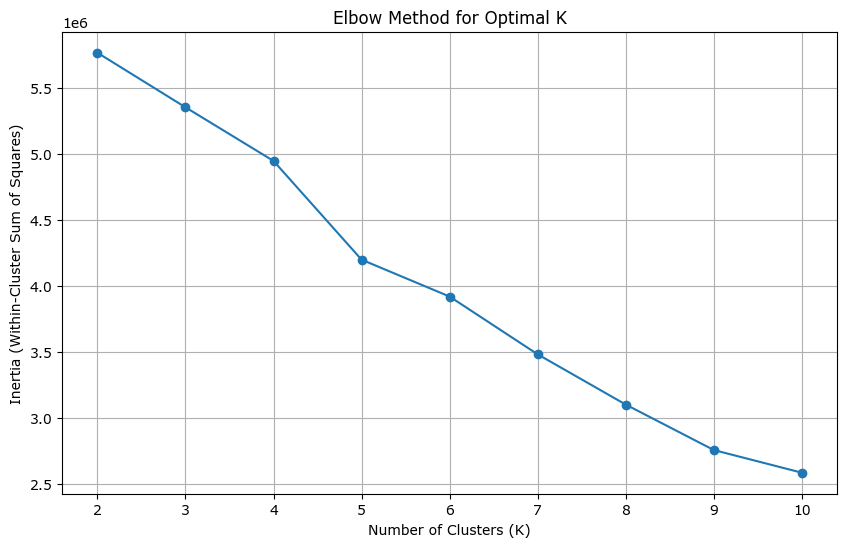

In [31]:
if processed_customer_df.empty:
    print("Processed customer DataFrame is empty. Skipping Elbow method.")
else:
    print("\n--- Determining Optimal K using Elbow Method ---")
    inertia = []
    k_range = range(2, 11) # Test K from 2 to 10 clusters

    for k_val in k_range:
        kmeans_model = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
        kmeans_model.fit(processed_customer_df)
        inertia.append(kmeans_model.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

Based on the Elbow plot from the previous step, choose a value for `K_CLUSTERS`. This is typically where the "elbow" (a significant bend) in the plot occurs, indicating a point where adding more clusters provides diminishing returns in variance reduction.

For example, if the elbow is at K=3 or K=4, set `K_CLUSTERS` accordingly.

In [32]:
if processed_customer_df.empty:
    print("Processed customer DataFrame is empty. Skipping K-Means clustering.")
    customer_df_final = pd.DataFrame() # Ensure it's defined for later checks
else:
    print("\n--- Performing K-Means Clustering ---")
    # SET THIS VALUE BASED ON YOUR ELBOW PLOT:
    K_CLUSTERS = 4 # Example value, adjust as needed
    print(f"Using K = {K_CLUSTERS} clusters.")

    kmeans_final_model = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
    cluster_labels = kmeans_final_model.fit_predict(processed_customer_df)
    
    # Add cluster labels back to the original customer_df (or an imputed version of it for easier interpretation)
    # For interpretation, use the customer_df *before* scaling but *after* imputation of its own NaNs
    
    customer_df_imputed_for_interpretation = customer_df.copy()
    # Impute NaNs in the original feature set if any, for cleaner cluster averages
    for col in customer_df_imputed_for_interpretation.columns:
        if customer_df_imputed_for_interpretation[col].isnull().any():
            median_val = customer_df_imputed_for_interpretation[col].median()
            customer_df_imputed_for_interpretation[col].fillna(median_val, inplace=True)
            
    customer_df_final = customer_df_imputed_for_interpretation.copy() # Use this for analysis
    customer_df_final['cluster_id'] = cluster_labels
    
    print(f"\nCustomers with assigned cluster IDs (sample):")
    print(customer_df_final[['cluster_id'] + customer_df.columns.tolist()[:3]].head()) # Show cluster and a few features


--- Performing K-Means Clustering ---
Using K = 4 clusters.

Customers with assigned cluster IDs (sample):
           cluster_id  num_reviews  avg_rating_given  prop_recommended
client_id                                                             
538863              1            1               1.0               0.0
540761              0            1               2.0               1.0
549704              0            1               5.0               1.0
553815              0            1               5.0               1.0
557770              0            1               5.0               1.0


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\2029087165.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df_imputed_for_interpretation[col].fillna(median_val, inplace=True)



--- Analyzing Cluster Characteristics ---

Cluster Summary (Mean feature values and size per cluster):
            num_reviews  avg_rating_given  prop_recommended  \
cluster_id                                                    
0              1.881984          4.662602          0.987712   
1              3.645388          2.375977          0.244829   
2              2.280920          4.417640          0.879694   
3              1.721842          4.482539          0.939659   

            avg_price_reviewed  total_value_reviewed  \
cluster_id                                             
0                    45.545910             88.859213   
1                    46.859191            189.484033   
2                    49.805157            110.102089   
3                    48.605999             90.407039   

            avg_product_rating_reviewed  avg_loves_count_reviewed  \
cluster_id                                                          
0                              4.297241   

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\403479959.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y='avg_price_reviewed', data=cluster_summary, ax=axes[0], palette="PuRd")
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_19900\403479959.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y='avg_rating_given', data=cluster_summary, ax=axes[1], palette="RdPu")


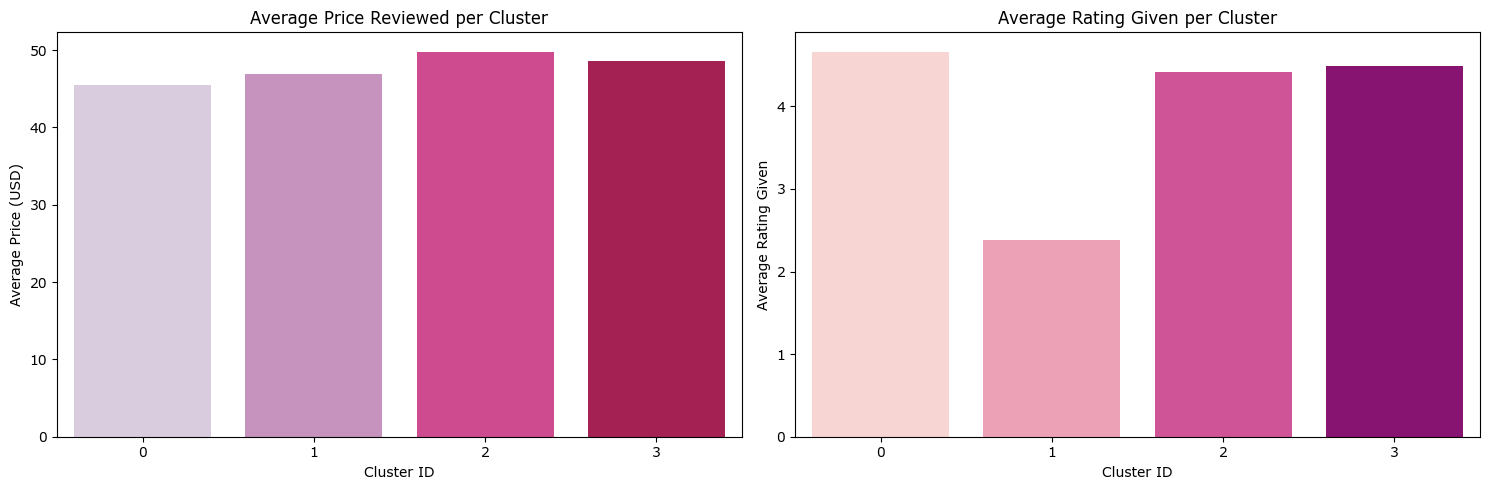

In [36]:
if 'customer_df_final' not in locals() or customer_df_final.empty:
    print("Final customer DataFrame with clusters is not available. Skipping cluster analysis.")
else:
    print("\n--- Analyzing Cluster Characteristics ---")
    # Calculate mean feature values for each cluster
    cluster_summary = customer_df_final.groupby('cluster_id').mean()
    
    # Also get cluster sizes
    cluster_sizes = customer_df_final['cluster_id'].value_counts().sort_index()
    cluster_summary['cluster_size'] = cluster_sizes
    
    print("\nCluster Summary (Mean feature values and size per cluster):")
    print(cluster_summary)
    
    # Example: Visualize 'avg_price_reviewed' and 'avg_rating_given' per cluster
    if 'avg_price_reviewed' in cluster_summary.columns and 'avg_rating_given' in cluster_summary.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        sns.barplot(x=cluster_summary.index, y='avg_price_reviewed', data=cluster_summary, ax=axes[0], palette="PuRd")
        axes[0].set_title('Average Price Reviewed per Cluster')
        axes[0].set_xlabel('Cluster ID')
        axes[0].set_ylabel('Average Price (USD)')
        
        sns.barplot(x=cluster_summary.index, y='avg_rating_given', data=cluster_summary, ax=axes[1], palette="RdPu")
        axes[1].set_title('Average Rating Given per Cluster')
        axes[1].set_xlabel('Cluster ID')
        axes[1].set_ylabel('Average Rating Given')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Note: 'avg_price_reviewed' or 'avg_rating_given' not available for plotting cluster summary.")

In [34]:
if 'customer_df_final' not in locals() or customer_df_final.empty or 'cluster_id' not in customer_df_final.columns:
    print("Clustering was not performed or 'cluster_id' is missing. Skipping export of segments.")
else:
    print("\n--- Exporting Customer Segments ---")
    # Create DataFrame with client_id (index) and cluster_id
    output_df = customer_df_final[['cluster_id']].reset_index()
    # 'client_id' is already the name of the index after reset_index() if it was named
    
    output_filename = "customer_segments.csv"
    try:
        output_df.to_csv(output_filename, index=False)
        print(f"Successfully exported customer segments to {output_filename}")
        print("Output CSV sample:")
        print(output_df.head())
    except Exception as e:
        print(f"Error exporting CSV: {e}")


--- Exporting Customer Segments ---
Successfully exported customer segments to customer_segments.csv
Output CSV sample:
   client_id  cluster_id
0     538863           1
1     540761           0
2     549704           0
3     553815           0
4     557770           0


## Conclusion & Next Steps

This notebook has performed customer segmentation based on Sephora product reviews and associated product data. The key output is `customer_segments.csv`, which maps each `client_id` to a `cluster_id`.

**Interpretation of Clusters:**
Analyze the `Cluster Summary` table from Cell 9 to understand the defining characteristics of each segment. For example:
* Are there high-spenders? Budget-conscious shoppers?
* Do some clusters prefer specific brands or categories (this would require more detailed feature engineering not fully implemented here, but `num_unique_brands/categories` gives a hint)?
* Are there highly engaged reviewers vs. infrequent ones?

**Potential Next Steps & Improvements:**
* **Deeper Feature Engineering:**
    * Analyze review text (e.g., sentiment analysis per customer, common topics/keywords mentioned). Libraries like NLTK or spaCy (listed in `requirements.txt`) would be useful here.
    * Create more granular brand/category preference features (e.g., proportion of reviews for top N brands/categories, average rating per preferred brand).
    * Consider product ingredient analysis if relevant.
* **Advanced Clustering Techniques:** Experiment with other algorithms like DBSCAN or Agglomerative Clustering, especially if K-Means assumptions don't fit the data well.
* **Cluster Validation:** Use metrics like Silhouette Score to more formally evaluate cluster quality.
* **Actionable Insights:** Translate cluster characteristics into actionable business strategies (e.g., targeted promotions, personalized recommendations).
* **Visualization:** Enhance cluster understanding with more detailed visualizations (e.g., radar charts for feature comparison, t-SNE/UMAP for visualizing clusters in 2D).